# This notebook implements the routine for low SNR edge fitting

        What it should be done:
            - load source spectrum
            - load material attenuation spectrum
            - apply poisson noise according to flux, pixels, exposure time
            - provide different fitting methods:
                - S-G filter: smoothing of 1D signal
                - 3D moving average convolution
                - fit with weights by covariance found in space domain

In [8]:
import math 
import h5py 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy.io
import pylab as pl
%matplotlib inline  
#%matplotlib notebook

import sys
sys.path.append('C:\\Users\\busi_m\\Workspace\\neutronimaging\\ToFImaging')
from lib import srcs
from lib import mats

# Loading spectra

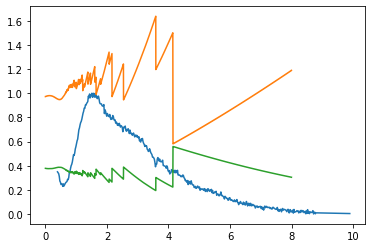

In [10]:
ICON = srcs.ICON_spectrum()
mu = mats.Fe_gamma()



T=mu
T[:,0] = mu[:,0]
T[:,1] = np.exp(-mu[:,1])

plt.plot(ICON[:,0],ICON[:,1])
plt.plot(mu[:,0],mu[:,1])
plt.plot(T[:,0],T[:,1])
plt.show()
plt.close()


# Apply Poisson noise

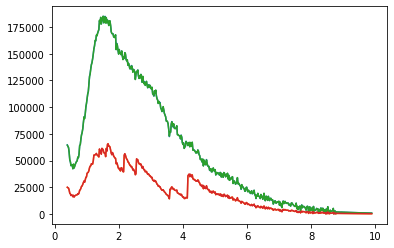

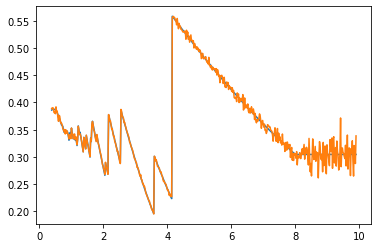

In [27]:
fps = 1.7e8  # source flux n /s/cm^2
npixel = 1 * 1  # number of pixels
exp_t = 60 * 60 * 1  # exposure time ( s * m * h)
pixel_s = 0.0055 * 0.0055
duty = 0.01
flux = fps * exp_t * npixel * pixel_s * duty

l = ICON[:,0]
y0 = flux*ICON[:,1]
T_int = np.interp(l, T[:, 0], T[:, 1])
y = y0*T_int
y0_n = np.random.poisson(y0)
y_n = np.random.poisson(y)
T_n = np.divide(y_n,y0_n)

plt.plot(l,y0)
plt.plot(l,y)
plt.plot(l,y0_n)
plt.plot(l,y_n)
plt.show()
plt.close()

plt.plot(l,T_int)
plt.plot(l,T_n)
plt.show()
plt.close()